In [1]:
!pip install lifelines
!pip install osqp==0.5
!pip install scikit-survival
!pip install pycox
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.7/349.7 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 KB 5.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=dad5961d3ca344d2e3d0b3a366d4d9e1bdd9c08f04f9befe1142ec224f78b2f8
  Stored in directory: /root/.cache/pip/wheels/16/a2/b6/582cfdfbeeccd469504a01af3bb952fd9e7eccba40995eafea
Successfully built autograd-gamma
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.0/209.0 KB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for osqp: filename=osqp-0.5.0-cp38-cp38-linux_x86_64.whl size=197470 sha256=49cf7e820599f6029766ecb05deed987cd70d5ad85e1683169593947e48e0cd5
  Stored in dir

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as opt
from torch.distributions.weibull import Weibull
from torch.distributions.log_normal import LogNormal
from torch.distributions.categorical import Categorical
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all
import math
from numbers import Real
from numbers import Number
from einops import rearrange
import pandas as pd
import numpy as np
import scipy.stats as ss
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lifelines.utils import concordance_index# as c_index
from sksurv.metrics import brier_score, integrated_brier_score, concordance_index_censored as ci_scikit
from copy import copy, deepcopy
import dask
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
'''torch.cuda.set_device(0)
torch.backends.cudnn.benchmark = True'''

Mounted at /content/drive


'torch.cuda.set_device(0)\ntorch.backends.cudnn.benchmark = True'

In [2]:
def non_censored_diagn(data, E, T, mlt, step):
    errors, churned = [], np.where(E)[0]
    bins = np.arange(min(T.iloc[churned]), max(T.iloc[churned]), step)
    for i in range(len(bins)-1):
        idx = data_test.loc[(data[event_column]==1) & (data[time_column]>=bins[i]) & (data[time_column]<=bins[i+1])].index.values
        errors.append(mean_absolute_error(T_test.iloc[idx], mlt[idx]))
    fig = make_subplots(rows=3, cols=1)
    # Add traces
    fig.append_trace(go.Scatter(x=T.iloc[churned].index, y=T.iloc[churned], mode='markers', name='TRUE'), row=1, col=1)
    fig.append_trace(go.Scatter(x=T.iloc[churned].index, y=mlt[churned], mode='markers', name='PRED'), row=1, col=1)
    fig.append_trace(go.Scatter(x=T.iloc[churned].index, y=np.abs(T.iloc[churned] - mlt[churned]), mode='lines', name='ERROS'), row=1, col=1)
    fig.append_trace(go.Scatter(x=[0, max(T.iloc[churned].index)], y=[mean_absolute_error(T.iloc[churned], mlt[churned])]*2, mode='lines', name='MAE'), row=1, col=1)
    fig.append_trace(go.Scatter(x=[0, max(T.iloc[churned].index)], y=[np.median(np.abs(T.iloc[churned] - mlt[churned]))]*2, mode='lines', name='MEDIAN'), row=1, col=1)
    fig.append_trace(go.Histogram(x=np.abs(T.iloc[churned] - mlt[churned]), histnorm='probability'), row=2, col=1)
    fig.append_trace(go.Scatter(x=bins[1:], y=errors), row=3, col=1)
    fig.update_layout(height=750)
    return fig

def plot_surv(idx, T, mlt, surv, times, vs=0.05):
    rows, cols, k = int(np.ceil(len(idx)/3)), 3, 0
    subplot_titles = ['Survival curve of '+str(c) for c in idx]
    surv_plot = make_subplots(rows=rows, cols=cols, shared_yaxes=True, subplot_titles=subplot_titles, horizontal_spacing = 0.01, vertical_spacing=vs)
    for i in range(rows):
        for j in range(cols):
          surv_plot.add_trace(go.Scatter(x=times, y=surv[:,idx[k]].flatten(), name=str(idx[k]), line=dict(color='#0000ff')), row=i+1, col=j+1)
          surv_plot.add_trace(go.Scatter(x=[T[idx[k]]]*10, y=np.linspace(0,1,10), mode='lines', line=dict(color='#ff0000')), row=i + 1, col=j + 1)
          surv_plot.add_trace(go.Scatter(x=[mlt[idx[k]]] * 10, y=np.linspace(0, 1, 10), mode='lines', line=dict(color='#00ff00')), row=i + 1, col=j + 1)
          k += 1
          if k >= len(idx):
            break
    surv_plot.update_layout(height=rows*300)
    return surv_plot

In [8]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/survival analysis/telecom_customer_churn/telecom.csv')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [6]:
pd.DataFrame({'Dtype': df.dtypes, 'Nunique': df.nunique(), 'Isnull': df.isnull().sum()}, index=df.columns)

,Dtype,Nunique,Isnull
customerID,object,7032,0
gender,object,2,0
SeniorCitizen,int64,2,0
Partner,object,2,0
Dependents,object,2,0
tenure,int64,72,0
PhoneService,object,2,0
MultipleLines,object,3,0
InternetService,object,3,0
OnlineSecurity,object,3,0


In [4]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [9]:
l = []
for j, i in enumerate(df['TotalCharges']):
    try:
        float(i)
    except ValueError:
        print(j, '_________', i)
        l.append(j)
df.drop(l, inplace = True ) 
df['TotalCharges'] = df['TotalCharges'].astype(float)
df = df.reset_index( drop = True )

488 _________  
753 _________  
936 _________  
1082 _________  
1340 _________  
3331 _________  
3826 _________  
4380 _________  
5218 _________  
6670 _________  
6754 _________  


In [10]:
time_column = 'tenure'
event_column = 'Churn'
to_remove = ['customerID']
features = [c for c in df.columns if (c not in [time_column, event_column]) and (c not in to_remove)]
categorical = [c for c in features if (df[c].dtype=='object') and (df[c].nunique() > 2)]
binary = [c for c in features if df[c].nunique() == 2]
numerical = [col for col in features if col not in categorical + binary]
df[numerical] = df[numerical].apply(pd.to_numeric,1)
df[time_column] = df[time_column]+0.1

df.replace({event_column: {'No': 0, 'Yes': 1}}, inplace=True)
fig = go.Figure(data=go.Heatmap(z=df[numerical].corr(),x=numerical,y=numerical))
fig.show()

In [11]:
from sklearn.model_selection import train_test_split

OE = OneHotEncoder(drop='if_binary', sparse=False)
df[binary] = OE.fit_transform(df[binary]).astype(int)


index_train, index_test = train_test_split(range(df.shape[0]), test_size=0.3, random_state=0, stratify=df[event_column])
tmp_data_train = df.loc[index_train].reset_index( drop = True )
data_test  = df.loc[index_test].reset_index( drop = True )

index_train, index_valid = train_test_split(tmp_data_train.index, test_size=0.2, random_state=0, stratify=tmp_data_train[event_column])
data_train = tmp_data_train.loc[index_train].reset_index( drop = True )
data_valid = tmp_data_train.loc[index_valid].reset_index( drop = True )

 
# Creating the X, T and E inputs
X_train, X_valid, X_test = data_train[features], data_valid[features], data_test[features]
T_train, T_valid, T_test = data_train[time_column], data_valid[time_column], data_test[time_column]
E_train, E_valid, E_test = data_train[event_column], data_valid[event_column], data_test[event_column]

cat_enc_d = {}
for cat in categorical+binary:
    print(cat)
    LE = LabelEncoder()
    X_train[cat] = LE.fit_transform(X_train[cat])
    X_valid[cat] = LE.transform(X_valid[cat])
    X_test[cat] = LE.transform(X_test[cat])
    cat_enc_d[cat] = LE
 
MS = MinMaxScaler(feature_range=(0, 1))
scaled_train = MS.fit_transform(X_train[numerical])
scaled_valid = MS.transform(X_valid[numerical])
scaled_test = MS.transform(X_test[numerical])
X_train[numerical], X_valid[numerical], X_test[numerical] = scaled_train, scaled_valid, scaled_test

X_train.shape, X_valid.shape, X_test.shape

MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaymentMethod
gender
SeniorCitizen
Partner
Dependents
PhoneService
PaperlessBilling


<ipython-input-11-d5634f598b44>:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-d5634f598b44>:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-d5634f598b44>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3

((3937, 18), (985, 18), (2110, 18))

In [ ]:
X_train

,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,0,0.0,0.073770,1,1,0.8,0.6,4,0.50,1,0.095238,0,0.200000,0.0625,0.066667,0.021739,0.423828
1,1,0.0,0.131148,4,1,0.6,0.6,0,0.00,1,0.000000,1,0.200000,0.1250,0.066667,0.065217,0.661867
2,0,0.0,0.032787,4,1,0.8,0.6,1,1.00,1,0.095238,0,0.266667,0.8750,0.933333,0.173913,0.936152
3,1,0.0,0.024590,4,1,0.8,0.8,5,0.00,2,0.333333,0,0.266667,0.1250,0.066667,0.021739,0.946645
4,1,0.5,0.016393,4,0,0.6,0.8,2,0.50,2,0.238095,0,0.066667,0.1250,0.066667,0.065217,0.568787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4341,1,0.0,0.254098,6,1,0.6,0.6,2,0.25,2,0.095238,0,1.000000,0.1250,0.066667,0.391304,0.524355
4342,1,0.0,0.008197,4,1,0.6,0.4,1,1.00,1,0.095238,0,0.000000,0.0625,0.666667,0.347826,0.825348
4343,0,0.0,0.008197,4,0,0.6,0.8,4,0.25,1,0.142857,0,0.200000,0.1250,0.066667,0.000000,0.441983
4344,2,0.0,0.024590,3,1,0.4,0.4,4,0.50,2,0.285714,0,0.400000,0.1250,0.066667,0.021739,0.442537


In [12]:
from torch import autograd

def sinc(x):
    x = x * np.pi
    return torch.where(x != 0., torch.sin(x) / x, 1.)

class LogLogistic(ExponentialFamily):
    arg_constraints = {'scale': constraints.positive}
    support = constraints.positive
    #has_rsample = True

    @property
    def mean(self):
        mean = torch.exp(self.loc) / sinc(self.scale)
        return torch.where(self.scale > 1., np.nan, mean).to(device)

    @property
    def variance(self):
        variance = torch.exp(2 * self.loc) * (1. / sinc(2 * self.scale) - 1. / sinc(self.scale)**2)
        return torch.where(self.scale > 0.5, np.nan, variance)

    def __init__(self, loc, scale, validate_args=None):
        self.loc, self.scale = broadcast_all(loc, scale)
        if isinstance(loc, Number) and isinstance(scale, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.loc.size()
        super(LogLogistic, self).__init__(batch_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(LogLogistic, _instance)
        batch_shape = torch.Size(batch_shape)
        new.loc = self.loc.expand(batch_shape)
        new.scale = self.scale.expand(batch_shape)
        super(LogLogistic, new).__init__(batch_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return ((value.log() - self.loc)/self.scale) - self.scale.log() - value.log() - 2*torch.log(1+torch.exp((value.log() - self.loc)/self.scale))

    def cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return 1/(1+torch.exp(-(value.log() - self.loc)/self.scale))
 
class SURV_DATA_LOADER(Dataset):
    def __init__(self, X, T, E, numerical_col, categorical_col):
        self.X1, self.X2, self.T, self.E = X[numerical_col].values.astype(np.float32), X[categorical_col].values, T.astype(np.float32), E.astype(np.bool)
 
    def __len__(self):
        return len(self.E)
 
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.T[idx], self.E[idx]

class Embedder(nn.Module):
    def __init__(self, embedding_sizes):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])

    def forward(self, x):
        x = [e(x[:,i]) for i,e in enumerate(self.embeddings)]
        return torch.cat(x, 1)

class NNModel(nn.Module):
    def __init__(self, input_shape, units=None, factors=None, activ=True, norm=False, dropout=False, slops=None):
        super().__init__()
        self.input_shape = input_shape
        self.units = units
        self.factors = factors
        self.activ, self.norm = activ, norm
        self.network = nn.ModuleList()
        if self.factors:
            self.units = np.round(self.input_shape * np.asarray(self.factors)).astype(int)
        if self.units is not None:
            self.dropout = np.zeros_like(self.units) if not dropout else dropout
            self.slops = np.full(len(self.units), 1) if slops is None else slops
            for i, j, k in zip(self.units, self.dropout, self.slops):
                if i >= 1:
                    block = self.__build_block__(input_shape, i, p=j, slop=k)
                    self.network.extend(block)
                    input_shape = i
        self.output_shape = input_shape
        self.reset_parameters()
    
    def __build_block__(self, input_shape, units, p, slop):
        block = []
        block.append(nn.Linear(input_shape, units, bias=not self.norm))
        if self.norm:
            block.append(nn.BatchNorm1d(units))
            #block.append(nn.LayerNorm(units, eps=1e-5))
        if self.activ:
            #block.append(nn.LeakyReLU())
            block.append(nn.ELU(slop))
            #block.append(nn.GELU())
        if p > 0:
            block.append(nn.Dropout(p))
        return block
 
    def forward(self, x):
        for layer in self.network:
          tmp = layer(x)
          x = tmp
        return x
 
    def reset_parameters(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                layer.bias.data.fill_(0.1)
 
 
class TabMLP(nn.Module):
    def __init__(self, vocab_size, embed_size, numerical, mlp_units, mlp_dropout=0.00001):
        """
        categories: tuple containing the number of unique values within each category
        """
        super().__init__()
        embedding_sizes = list(zip(vocab_size, embed_size))
        self.cat_embedder = Embedder(embedding_sizes)
        self.norm = nn.BatchNorm1d(numerical, eps=1e-5)
        input_size = numerical + sum(embed_size)
        self.mlp = NNModel(int(input_size), units=mlp_units, factors=None, dropout=[mlp_dropout]*len(mlp_units))
        self.output_shape = mlp_units[-1]

    def forward(self, x_cont, x_cat):
        x = x_cont
        if x_cat.nelement() != 0: #skipped if there's no categorical feature
            x_ = self.cat_embedder(x_cat)
            x = self.norm(x)
            x = torch.cat([x_, x], 1)
        return self.mlp(x)

class MDN(nn.Module):
    def __init__(self, shared, clf_nn, alpha_nn, beta_nn, n_comp):
        super(MDN, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.shared = shared
        self.clf_nn = clf_nn
        self.alpha_nn = alpha_nn
        self.beta_nn = beta_nn
        self.n_comp = n_comp
        self.pi = nn.Linear(self.clf_nn.output_shape, self.n_comp) if self.n_comp > 1 else None
        self.ai = nn.Linear(self.alpha_nn.output_shape, self.n_comp)
        self.bi = nn.Linear(self.beta_nn.output_shape, self.n_comp)
 
    def forward(self, x_cont, x_cat):
        x = self.shared(x_cont, x_cat)
        proba = self.proba_model(x) if self.n_comp > 1 else torch.ones((len(x),1)).to(self.device)
        alpha = self.alpha_model(x)
        beta = self.beta_model(x)
        return proba, alpha, beta
 
    def proba_model(self, x):
        model = self.clf_nn(x)
        model = self.pi(model)
        model = nn.Softmax(dim=-1)(model)
        return model
 
    def alpha_model(self, x):
        model = self.alpha_nn(x)
        model = self.ai(model)
        return model
 
    def beta_model(self, x):
        model = self.beta_nn(x)
        model = self.bi(model)
        return model

class BaseParametric:
    def __init__(self, model, num_time_bins, numerical_col, categorical_col, resume=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.losses = {'Epoch': [], 'Train': [], 'Test': [], 'BState': [], 'LState': [], 'LR': []}
        self.num_time_bins = num_time_bins
        self.numerical_col, self.categorical_col = numerical_col, categorical_col
        self.times = None
        self.optim = resume
 
    def train_model(self, optim, train_loader, grad_clip, l2_reg):
          total_loss = 0
          self.model = self.model.train()
        #with autograd.detect_anomaly():
          for i, (X1, X2, T, E) in enumerate(train_loader):
              X1, X2, T, E = X1.to(self.device), X2.to(self.device), T.to(self.device), E.to(self.device)
              #self.model.get_weight()
              self.optim.zero_grad()
              loss = self.loss_function(X1, X2, T, E, l2_reg)
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.model.parameters(), grad_clip)
              self.optim.step()
              '''self.model.get_grad()
              print('_'*50)'''
              total_loss += loss.item()
          return total_loss/(i+1)
        
 
    def eval_model(self, test_loader):
        self.model = self.model.eval()
        total_loss = 0
        for i, (X1, X2, T, E) in enumerate(test_loader):
            X1, X2, T, E = X1.to(self.device), X2.to(self.device), T.to(self.device), E.to(self.device)
            loss = self.loss_function(X1, X2, T, E, l2_reg=0)
            total_loss += loss.item()
        return total_loss/(i+1)#np.abs(-100. - total_loss)
 
 
    def fit(self, X_train, T_train, E_train, epoch, lr, opt_kwarg, batch_size=None,  grad_clip=100, momentum=0.9, is_min_time_zero=False, extra_pct_time=0.1,
            X_test=None, T_test=None, E_test=None, l2_reg=0, eval=True, verbose=True, save=True):
        
        min_t = 0 if is_min_time_zero else min(T_train)
        max_t = max(T_train)*(1+extra_pct_time)
        self.times = np.linspace(min_t, max_t, self.num_time_bins)
 
        batch_size = len(X_train) if batch_size is None else batch_size
        #X_train_uncens, Y_train_uncens, T_train_uncens, X_train_cens, Y_train_cens, T_train_cens = self.process_data(X_train, T_train, E_train)
        train_load = DataLoader(SURV_DATA_LOADER(X_train, T_train, E_train, self.numerical_col, self.categorical_col), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        if X_test is not None:
            #X_test_uncens, Y_test_uncens, T_test_uncens, X_test_cens, Y_test_cens, T_test_cens = self.process_data(X_test, T_test, E_test)
            test_load = DataLoader(SURV_DATA_LOADER(X_test, T_test, E_test, self.numerical_col, self.categorical_col), batch_size=batch_size, shuffle=True)  # DATALOADER obj
 
        best_loss = 1e100
        #self.optim = opt.Adam(self.model.parameters(), lr=lr)
        self.optim = opt.SGD(self.model.parameters(), lr=lr, momentum=momentum, nesterov=True)

        #scheduler = None
        scheduler = opt.lr_scheduler.CyclicLR(self.optim, **opt_kwarg)
        #scheduler = opt.lr_scheduler.ReduceLROnPlateau(self.optim, **opt_kwarg)
        #scheduler = opt.lr_scheduler.MultiStepLR(self.optim, milestones=[28, 120], gamma=0.1)

        eval_score = ''
        for i in range(epoch):
            if verbose:
                print('##### EPOCH ' + str(i) + ' #####')
               
            train_loss = self.train_model(self.optim, train_load, grad_clip, l2_reg)
            self.losses['LState'] = deepcopy(self.model.state_dict())
    
            if verbose:
                print('train loss : ', train_loss)
            self.losses['Epoch'].append(i), self.losses['Train'].append(train_loss)
    
            if X_test is not None:
                valid_loss = self.eval_model(test_load)

                if verbose:
                    print('test loss : ', valid_loss)
                self.losses['Test'].append(valid_loss)
    
                if scheduler is not None:
                    '''scheduler.step(valid_loss)
                    self.losses['LR'].append(self.optim.param_groups[0]['lr'])'''
                    scheduler.step()
                    self.losses['LR'].append(scheduler.get_last_lr()[0])
    
                if valid_loss < best_loss:
                    self.losses['BState'] = deepcopy(self.model.state_dict())
                    best_loss = valid_loss
                    print('===========SAVE===========')
                    
 
    def b_index(self, X_train, T_train, E_train, X_test, T_test, E_test, survival, plot=True):
        time_idx = self.times[np.argmin(self.times<min(T_test)):np.argmax(self.times>max(T_test)) - 1] #don't keep times index that are beyond max(T_train)
        train_e_t = np.asarray(list(zip(E_train.astype(np.bool), T_train)), dtype='|bool, i4') #concat event and time
        test_e_t = np.asarray(list(zip(E_test.astype(np.bool), T_test)), dtype='|bool, i4')
        brier_res = []
        for j, i in enumerate(time_idx):
            _, score = brier_score(train_e_t, test_e_t, survival[:,j], i)
            brier_res.append(score[0])
        ibs = np.trapz(brier_res, time_idx)/max(T_train)
        if plot:
            figure = self.plot_brier_curve(time_idx, brier_res, ibs)
            return brier_res, ibs, figure
        else:
            return brier_res, ibs

    def c_index(self, mlt, t, e):
        #mlt = torch.sum(p * alpha * torch.lgamma(1 + (1/beta)).exp(), 1).cpu().data.numpy() #WEIBULL
        #mlt = torch.sum(p * torch.exp(alpha + torch.pow(beta, 2)/2), 1).data.numpy() #LOGNORMAL
        res = 1 - ci_scikit(e.astype(np.bool), t, mlt)[0]
        return res
 
    def plot_brier_curve(self, time_axis, score, ibs):
        fig, ax = plt.subplots(figsize=(8, 4))
        plt.plot(time_axis, score, color='blue', label='Brier score / time', lw=2)
 
        plt.axhline(y=0.25, color='black', linestyle='-')
        #ax.annotate('0.25', xy=(1, 0.5), xytext=(t, 0.5), fontsize=12)
 
        title = "Integrated Brier Score: " + str(ibs)
        plt.legend(fontsize=12)
        plt.title(title, fontsize=15)
        plt.ylim(0, 1.05)
        return plt

    def feature_importance(self, rep, X_test, T_test, E_test, batch_size=None):
        res = np.zeros((rep, X_test.shape[1]))
        batch_size = len(X_train) if batch_size is None else batch_size
        test_load = DataLoader(SURV_DATA_LOADER(X_test, T_test, E_test, self.numerical_col, self.categorical_col), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        base_loss = self.eval_model(test_load)
        origin = X_test.copy()
        for i, col in enumerate(X_test.columns):
            for j in range(rep):
                X_test.loc[:,col] = np.random.permutation(X_test.loc[:, col])
                test_load = DataLoader(SURV_DATA_LOADER(X_test, T_test, E_test, self.numerical_col, self.categorical_col), batch_size=batch_size, shuffle=True)  # DATALOADER obj
                loss = self.eval_model(test_load)
                res[j, i] = base_loss - loss
                X_test = origin
        res = np.abs(res)
        return {'importances': res, 'importances_mean': np.mean(res, 0), 'importances_std': np.std(res, 0)}

class WeibullModel(BaseParametric):
    def __init__(self, model, num_time_bins, numerical_col, categorical_col,resume=None):
        super(WeibullModel, self).__init__(model, num_time_bins, numerical_col, categorical_col,)

    def loss_function(self, X1, X2, T, E, l2_reg):
        pi, alpha, beta = self.model(X1, X2)
        alpha = nn.ELU()(alpha) + 1 + 1e-15 #WEIBULL
        beta = nn.ELU()(beta) + 2 #WEIBULL
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        loss = torch.where(E, mixture.log_prob(T), torch.log(torch.clamp(1 - mixture.cdf(T), min=1e-25)))
        loss = -torch.mean(loss)
        return loss

    def prdict_survival(self, X):
        self.model.eval()
        X1 = torch.tensor(X[self.numerical_col].values.astype(np.float32)).to(self.device)
        X2 = torch.tensor(X[self.categorical_col].values).to(self.device)
        T = (torch.FloatTensor(self.times[:,np.newaxis,np.newaxis].astype(np.float32)) + 1e-5).to(self.device)
        pi, alpha, beta = self.model(X1, X2)
        alpha = nn.ELU()(alpha) + 1 + 1e-15 #WEIBULL
        beta = nn.ELU()(beta) + 2 #WEIBULL
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        surv = 1 - mixture.cdf(T)
        return pi, alpha, beta, surv, mixture.mean

class LogNormalModel(BaseParametric):
    def __init__(self, model, num_time_bins, numerical_col, categorical_col,resume=None):
        super(LogNormalModel, self).__init__(model, num_time_bins, numerical_col, categorical_col,)

    def loss_function(self, X1, X2, T, E, l2_reg):
        pi, mu, std = self.model(X1, X2)
        std = nn.ELU()(std) + 1 + 1e-15 #LOGNORMAL
        mix = Categorical(pi)
        comp = LogNormal(mu, std, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        loss = torch.where(E, mixture.log_prob(T), torch.log(torch.clamp(1 - mixture.cdf(T), min=1e-25)))
        loss = -torch.mean(loss)
        return loss

    def prdict_survival(self, X):
        self.model.eval()
        X1 = torch.tensor(X[self.numerical_col].values.astype(np.float32)).to(self.device)
        X2 = torch.tensor(X[self.categorical_col].values).to(self.device)
        T = (torch.FloatTensor(self.times[:,np.newaxis,np.newaxis].astype(np.float32)) + 1e-5).to(self.device)
        pi, mu, std = self.model(X1, X2)
        std = nn.ELU()(std) + 1 + 1e-15 #LOGNORMAL
        mix = Categorical(pi)
        comp = LogNormal(mu, std, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        surv = 1 - mixture.cdf(T)
        return pi, mu, std, surv, mixture.mean

class LogLogisticModel(BaseParametric):
    def __init__(self, model, num_time_bins, numerical_col, categorical_col,resume=None):
        super(LogLogisticModel, self).__init__(model, num_time_bins, numerical_col, categorical_col,)

    def loss_function(self, X1, X2, T, E, l2_reg):
        pi, mu, std = self.model(X1, X2)
        mu = torch.where(mu>0, torch.tanh(mu), mu)
        std = ((1 - torch.exp(-torch.sigmoid(std))) * 0.5) #MAKE STD BETWEEN 0 AND 0.5
        mix = Categorical(pi)
        comp = LogLogistic(mu, std, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        loss = torch.where(E, mixture.log_prob(T), torch.log(torch.clamp(1 - mixture.cdf(T), min=1e-25)))
        loss = -torch.mean(loss)
        return loss

    def prdict_survival(self, X):
        self.model.eval()
        X1 = torch.tensor(X[self.numerical_col].values.astype(np.float32)).to(self.device)
        X2 = torch.tensor(X[self.categorical_col].values).to(self.device)
        T = (torch.FloatTensor(self.times[:,np.newaxis,np.newaxis].astype(np.float32)) + 1e-5).to(self.device)
        pi, mu, std = self.model(X1, X2)
        mu = torch.where(mu>0, torch.tanh(mu), mu)
        std = ((1 - torch.exp(-torch.sigmoid(std))) * 0.5) #MAKE STD BETWEEN 0 AND 0.5
        mix = Categorical(pi)
        comp = LogLogistic(mu, std, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        surv = 1 - mixture.cdf(T)
        return pi, mu, std, surv, mixture.mean
 
def gradient_clipper(model: nn.Module, val: float) -> nn.Module:
    def process_grad(grad):
        grad[grad != grad] = 1e-10
        return torch.clamp(grad, -val, val)
    for parameter in model.parameters():
        parameter.register_hook(lambda grad: process_grad(grad))
    
    return model

In [13]:
n_comp, epoch, lr, batch_size, d, mlp_d = 2, 50000, 1e-5, None, 0.000001, 1e-6
cyclic_kwarg = {'base_lr': lr, 'max_lr': 1e-2, 'step_size_up':200, 'step_size_down':200}
plateau_kwarg = {'factor':0.5, 'patience':200, 'verbose':True, 'min_lr':1e-7, 'mode':'min'}
embed_size = np.ceil(np.sqrt(list(X_train[categorical+binary].nunique()))).astype(int)

shared_nn = TabMLP(df[categorical+binary].nunique(), embed_size, len(numerical), [128, 512, 768, 512], mlp_dropout=mlp_d)
clf_nn = NNModel(shared_nn.output_shape , units=[128], factors=None, dropout=[mlp_d])
alpha_nn = NNModel(shared_nn.output_shape, units=[128], factors=None, dropout=[mlp_d])
beta_nn = NNModel(shared_nn.output_shape, units=[128], factors=None, dropout=[mlp_d])#, dropout=[d,d,d,d]

nn_model = gradient_clipper(MDN(shared_nn, clf_nn, alpha_nn, beta_nn, n_comp), 10)
#nn_model.load_state_dict(best_state)
print(nn_model)
print(sum(p.numel() for p in nn_model.parameters() if p.requires_grad))
dws = LogNormalModel(nn_model, int(T_train.max()*1.1), numerical, categorical+binary)
dws.fit(X_train, T_train.values, E_train.values, epoch, lr, cyclic_kwarg, batch_size=batch_size, grad_clip=10, momentum=0.9,
        X_test=X_valid, T_test=T_valid.values, E_test=E_valid.values, l2_reg=0, eval=False, verbose=True, is_min_time_zero=True, extra_pct_time=0.1)

MDN(
  (shared): TabMLP(
    (cat_embedder): Embedder(
      (embeddings): ModuleList(
        (0): Embedding(3, 2)
        (1): Embedding(3, 2)
        (2): Embedding(3, 2)
        (3): Embedding(3, 2)
        (4): Embedding(3, 2)
        (5): Embedding(3, 2)
        (6): Embedding(3, 2)
        (7): Embedding(3, 2)
        (8): Embedding(3, 2)
        (9): Embedding(4, 2)
        (10): Embedding(2, 2)
        (11): Embedding(2, 2)
        (12): Embedding(2, 2)
        (13): Embedding(2, 2)
        (14): Embedding(2, 2)
        (15): Embedding(2, 2)
      )
    )
    (norm): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (mlp): NNModel(
      (network): ModuleList(
        (0): Linear(in_features=34, out_features=128, bias=True)
        (1): ELU(alpha=1)
        (2): Dropout(p=1e-06, inplace=False)
        (3): Linear(in_features=128, out_features=512, bias=True)
        (4): ELU(alpha=1)
        (5): Dropout(p=1e-06, inplace=False)
        (6): Lin

<ipython-input-12-78887f3f6ff7>:51: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Streaming output truncated to the last 5000 lines.
test loss :  0.5216731429100037
##### EPOCH 5739 #####
train loss :  0.3678881525993347
test loss :  0.5172423124313354
##### EPOCH 5740 #####
train loss :  0.359671413898468
test loss :  0.509398877620697
##### EPOCH 5741 #####
train loss :  0.3496251702308655
test loss :  0.5044997930526733
##### EPOCH 5742 #####
train loss :  0.33831825852394104
test loss :  0.4961390793323517
##### EPOCH 5743 #####
train loss :  0.3269287943840027
test loss :  0.5020025968551636
##### EPOCH 5744 #####
train loss :  0.3196960985660553
test loss :  0.6077563166618347
##### EPOCH 5745 #####
train loss :  0.4470559060573578
test loss :  1.2219165563583374
##### EPOCH 5746 #####
train loss :  0.9777176976203918
test loss :  1.039789080619812
##### EPOCH 5747 #####
train loss :  0.8876229524612427
test loss :  1.25059974193573
##### EPOCH 5748 #####
train loss :  0.866152286529541
test loss :  0.7922547459602356
##### EPOCH 5749 #####
train loss :  0.676

KeyboardInterrupt: ignored

In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

best_state = deepcopy(dws.losses['BState'])
dws.model.load_state_dict(best_state)
print(np.min(dws.losses['Test']))

fig = make_subplots(rows=3, cols=1)
s = 0
model = dws
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['Train'][s:],mode='lines',name='Train'), row=1, col=1)
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['Test'][s:],mode='lines',name='Test'), row=2, col=1)
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['LR'][s:],mode='lines',name='LR'), row=3, col=1)
fig.update_layout(height=1000, width=1500, title_text="Stacked Subplots")
fig.show()

0.4379885494709015


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:159: UserWarning:

pylab import has clobbered these variables: ['copy', 'sinc']
`%matplotlib` prevents importing * from pylab and numpy

<ipython-input-12-78887f3f6ff7>:267: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-12-78887f3f6ff7>:268: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-note

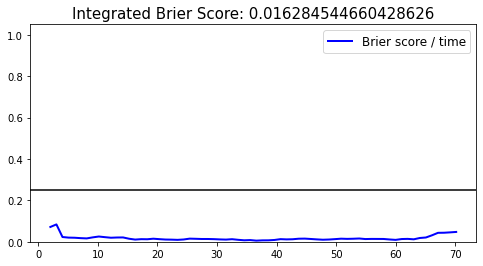

0.9844398885559585


<ipython-input-12-78887f3f6ff7>:283: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [15]:
from matplotlib import pyplot as plt
%pylab inline

pi, mu, std, survival_predictions, mlt = dws.prdict_survival(X_valid)
pi, mu, std, survival_predictions, mlt = pi.cpu(), mu.cpu(), std.cpu(), survival_predictions.cpu(), mlt.cpu().data.numpy()
survival_predictions = np.squeeze(survival_predictions.data.numpy())

brier_res, ibs, figure = dws.b_index(X_train.values, T_train, E_train.astype(float), X_valid.values, T_valid, E_valid.astype(float), survival_predictions.T, plot=True)
figure.show()
c_index = dws.c_index(mlt, T_valid, E_valid)
print(c_index)

<ipython-input-12-78887f3f6ff7>:267: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-12-78887f3f6ff7>:268: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



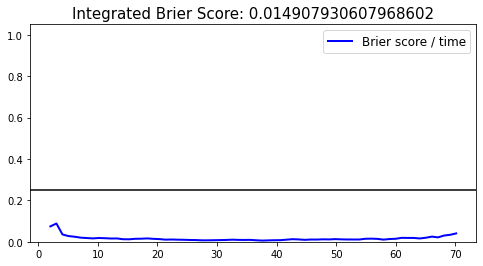

0.9860215376496174


<ipython-input-12-78887f3f6ff7>:283: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [16]:
pi, mu, std, survival_predictions, mlt = dws.prdict_survival(X_test)
pi, mu, std, survival_predictions, mlt = pi.cpu(), mu.cpu(), std.cpu(), survival_predictions.cpu(), mlt.cpu().data.numpy()
survival_predictions = np.squeeze(survival_predictions.data.numpy())

brier_res, ibs, figure = dws.b_index(X_train.values, T_train, E_train.astype(float), X_test.values, T_test, E_test.astype(float), survival_predictions.T, plot=True)
figure.show()
c_index = dws.c_index(mlt, T_test, E_test)
print(c_index)

In [20]:
non_censored_diagn(data_test, E_test, T_test, mlt, 2).show()

In [18]:
pd.DataFrame(data={'Event': E_test, 'True': T_test, 'PRED': mlt})

,Event,True,PRED
0,0,72.1,88.774818
1,0,66.1,65.718529
2,0,45.1,50.405388
3,0,72.1,95.597328
4,0,68.1,74.768799
...,...,...,...
2105,0,70.1,83.032562
2106,1,66.1,68.524544
2107,0,72.1,91.093033
2108,0,72.1,78.732193


In [22]:
idx = data_test.loc[(data_test[event_column]==1) & (data_test[time_column]>=25) & (data_test[time_column]<=30)].index.values
plot_surv(idx, T_test, mlt, survival_predictions, dws.times, vs=0.01).show()

In [23]:
imp = dws.feature_importance(10, X_test, T_test, E_test, batch_size=None)
fig = go.Figure()
for i in range(X_test.shape[1]):
    fig.add_trace(go.Box(x=imp['importances'][:, i], name=X_test.columns[i]))
fig.show()

<ipython-input-12-78887f3f6ff7>:51: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fig.write_html("/content/drive/My Drive/Colab Notebooks/survival analysis/phoenix_employee_attrition/phoenix_data/feat_imp.html")

In [ ]:
surv = pd.DataFrame(survival_predictions)
times = pd.DataFrame(dws.times, columns=['Times'])
res = pd.concat((times, surv), 1)
data_test.to_csv('/content/drive/My Drive/Colab Notebooks/survival analysis/phoenix_employee_attrition/phoenix_data/test_data.csv', index=False)
res.to_csv('/content/drive/My Drive/Colab Notebooks/survival analysis/phoenix_employee_attrition/phoenix_data/surve_curve.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [ ]:
pi[127]

tensor([0.5385, 0.3855, 0.0760], grad_fn=<SelectBackward0>)

In [ ]:
mu

tensor([[ 3.8614,  0.9315,  3.2493],
        [ 1.3498, -1.0948,  2.3471],
        [ 0.3427, -0.0226,  1.5585],
        ...,
        [ 0.8125, -2.1283,  1.4230],
        [ 1.2591,  0.3586,  2.1618],
        [ 2.6449,  0.5053,  2.6158]], grad_fn=<ToCopyBackward0>)

In [ ]:
std

tensor([[5.6644e-03, 5.0308e+00, 5.9187e-03],
        [8.3047e-03, 9.7209e+00, 6.9053e-03],
        [2.7909e-03, 5.8262e+00, 4.4599e-03],
        ...,
        [4.1315e-03, 1.5953e+01, 3.0430e-03],
        [7.9955e-03, 3.6421e+00, 4.6699e-03],
        [5.7642e-03, 6.3993e+00, 4.3525e-03]], grad_fn=<ToCopyBackward0>)

In [ ]:
(np.exp(-1.0948 + 9.7209e+00**2 / 2))

1.106770754511773e+20